In [8]:
#CW
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
from tools import show_images_diff

In [9]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="picture/cow.jpeg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()


(1, 3, 224, 224)


In [10]:
#adam的最大迭代次数 论文中建议10000次 测试阶段1000也可以 1000次可以完成95%的优化工作
max_iterations=1000
#adam学习速率
learning_rate=0.01
#二分查找最大次数
binary_search_steps=10
#c的初始值
initial_const=1e2
confidence=initial_const

#k值
k=40

#像素值区间
boxmin = -3.0
boxmax = 3.0

#类别数 pytorch的实现里面是1000
num_labels=1000

#攻击目标标签 必须使用one hot编码
target_label=288
tlab=Variable(torch.from_numpy(np.eye(num_labels)[target_label]).to(device).float())



shape = (1,3,224,224)


In [11]:


#c的初始化边界
lower_bound = 0
c=initial_const
upper_bound = 1e10

# the best l2, score, and image attack
o_bestl2 = 1e10
o_bestscore = -1
o_bestattack = [np.zeros(shape)]



In [12]:
# the resulting image, tanh'd to keep bounded from boxmin to boxmax
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.

for outer_step in range(binary_search_steps):
    print("o_bestl2={} confidence={}".format(o_bestl2,confidence)  )
    
    #把原始图像转换成图像数据和扰动的形态
    timg = Variable(torch.from_numpy(np.arctanh((img - boxplus) / boxmul * 0.999999)).to(device).float())
    modifier=Variable(torch.zeros_like(timg).to(device).float())
    

    #设置为不保存梯度值 自然也无法修改
    # for param in model.parameters():
    #    param.requires_grad = False
        
    #图像数据的扰动量梯度可以获取
    modifier.requires_grad = True
    

    #定义优化器 仅优化modifier
    optimizer = torch.optim.Adam([modifier],lr=learning_rate)
    
    for iteration in range(1,max_iterations+1):
        optimizer.zero_grad()
        
        #定义新输入
        newimg = torch.tanh(modifier + timg) * boxmul + boxplus
      
        output=model(newimg)
             
        #定义cw中的损失函数
        
        #l2范数
        loss2=torch.dist(newimg,(torch.tanh(timg) * boxmul + boxplus),p=2)
        
        """
        # compute the probability of the label class versus the maximum other
            real = tf.reduce_sum((tlab)*output,1)
            # 论文中的开源实现 other = tf.reduce_max((1-tlab)*output - (tlab*10000),1)
            other = tf.reduce_max((1-tlab)*output)
            loss1 = tf.maximum(0.0, other-real+k)
            loss1 = tf.reduce_sum(const*loss1)
        """
               
        real=torch.max(output*tlab)
        other=torch.max((1-tlab)*output)  
        loss1=other-real+k   
        loss1=torch.clamp(loss1,min=0)
             
        loss1=confidence*loss1
           
        loss=loss1+loss2
        
            
        loss.backward(retain_graph=True)

        optimizer.step()
              
        l2=loss2
        
        sc=output.data.cpu().numpy()
        
        # print out the losses every 10%
        if iteration%(max_iterations//10) == 0:
            print("iteration={} loss={} loss1={} loss2={}".format(iteration,loss,loss1,loss2))
              
        if (l2 < o_bestl2) and (np.argmax(sc) == target_label  ):
            print("attack success l2={} target_label={}".format(l2,target_label))
            o_bestl2 = l2
            o_bestscore = np.argmax(sc)
            o_bestattack = newimg.data.cpu().numpy()
            
    confidence_old=-1       
    if (o_bestscore == target_label) and o_bestscore != -1:
        #攻击成功 减小c
        upper_bound = min(upper_bound,confidence)
        if upper_bound < 1e9:
                print()
                confidence_old=confidence
                confidence = (lower_bound + upper_bound)/2
    else:
        lower_bound = max(lower_bound,confidence)
        confidence_old=confidence
        if upper_bound < 1e9:
                confidence = (lower_bound + upper_bound)/2
        else:
                confidence *= 10
                
    print("outer_step={} confidence {}->{}".format(outer_step,confidence_old,confidence))

o_bestl2=10000000000.0 confidence=100.0
attack success l2=58.01102828979492 target_label=288
iteration=100 loss=122.8177261352539 loss1=0.0 loss2=122.8177261352539
iteration=200 loss=128.36204528808594 loss1=0.0 loss2=128.36204528808594
iteration=300 loss=113.56753540039062 loss1=0.0 loss2=113.56753540039062
iteration=400 loss=138.04803466796875 loss1=0.0 loss2=138.04803466796875
iteration=500 loss=123.57601165771484 loss1=0.0 loss2=123.57601165771484
iteration=600 loss=127.68739318847656 loss1=0.0 loss2=127.68739318847656
iteration=700 loss=120.56193542480469 loss1=0.0 loss2=120.56193542480469
iteration=800 loss=122.8187484741211 loss1=0.0 loss2=122.8187484741211
iteration=900 loss=163.64244079589844 loss1=0.0 loss2=163.64244079589844
iteration=1000 loss=151.7821502685547 loss1=0.0 loss2=151.7821502685547

outer_step=0 confidence 100.0->50.0
o_bestl2=58.01102828979492 confidence=50.0
attack success l2=52.537071228027344 target_label=288
iteration=100 loss=117.01551818847656 loss1=0.0 

In [13]:
print(o_bestattack.shape)
print(img.shape)

(1, 3, 224, 224)
(1, 3, 224, 224)


(3, 224, 224)
l0=88133 l2=69710.03402667366


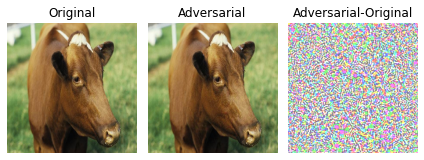

In [14]:
adv=o_bestattack[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

show_images_diff(orig,0,adv,0)